In [11]:

#!pip uninstall numba
!pip install numba==0.58.1

     ---------------------------------------- 2.6/2.6 MB 5.2 MB/s eta 0:00:00
     --------------------------------------- 28.1/28.1 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.42.0
    Uninstalling llvmlite-0.42.0:
      Successfully uninstalled llvmlite-0.42.0
  Attempting uninstall: numba
    Found existing installation: numba 0.59.1
    Uninstalling numba-0.59.1:
      Successfully uninstalled numba-0.59.1


In [3]:
!pip list --local > installed_packages.txt


In [6]:
!pip install ydata-profiling

In [1]:
# import the needed packages to create a data frame and run a profile report 
from pathlib import Path

import requests
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR 

from pandas_profiling.utils.cache import cache_file


C:\Users\iejoh\AppData\Local\Temp\ipykernel_6904\2181296662.py:18: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling.utils.cache import cache_file


In [2]:
# assign file paths to variables
prospects_file = 'raw_data/nfl_draft_prospects.csv.zip'
profiles_file = 'raw_data/nfl_draft_profiles.csv.zip'

# use pandas read csv to create data frames 

prospects_df = pd.read_csv(prospects_file)
profiles_df = pd.read_csv(profiles_file)


In [3]:
# merge data sets to make a complete data frame including both draft position and player description
complete_prospro = prospects_df.merge(profiles_df, how='left', on='player_id')


In [4]:
# drop columns that are not of use in analysis
useless_columns = ['position_x', 'school_abbr_x', 'school_y', 'school_abbr_y', 'school_name_y', 'link_y', 
                   'school_logo', 'traded', 'link_x', 'weight_x', 'height_x', 'pos_rk_x', 'ovr_rk_x', 'player_image_x',
                  'guid_y', 'player_name_y', 'weight_y', 'height_y', 'player_image_y', 'pos_rk_y', 'ovr_rk_y', 'grade_y',
                  'team_abbr', 'team_logo_espn', 'position_y', 'trade_note', 'pos_abbr_y']
complete_prospro = complete_prospro.drop(useless_columns, axis=1)

In [5]:
# subset the text columns and return a 0 for Nan and 1 for any other data type
with_text = pd.notna(complete_prospro[['text1', 'text2', 'text3', 'text4']])
# sum along the rows to see if the player observation contains values 
with_text = with_text.sum(axis=1)

In [6]:
# relable df
df = complete_prospro

In [7]:
# drop players that were not drafted (do not have a value for pick)
df = df.dropna(subset='pick')

In [8]:
report = df.profile_report(explorative=True, html={'style': {'full_width': True}})
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
df['grade_x'].unique()

array([98., 99., 96., 97., 94., 93., 90., 95., 91., nan, 78., 86., 85.,
       89., 88., 87., 92., 50., 74., 79., 66., 84., 65., 20., 70., 69.,
       64., 83., 75., 80., 58., 71., 82., 73., 77., 54., 63., 61., 57.,
       40., 60., 56., 37., 67., 55., 47., 81., 49., 72., 62., 41., 45.,
       59., 31., 30., 68., 51., 44., 48., 52., 36., 46., 42., 53., 43.,
       39., 34., 76., 38., 35., 33., 32.])

1. Initially I will be testing if player grades can be used to estimate player draft position better than random chance alone by using an r squared test on a model that gives the mean standard deviation from the sample to get and observed correlation statistic and then shuffling the scores using np.random_choice and reruning the sample 10000 times. I will then plot the distribution and see if the observed standard error p-value is extreme enough to land outside of the 95% confidence interval

2. Second of all I would like to test if using a natural language processed score from my text data can be used to improve the predictive power of my model compared to using the player grade alone.  For this I will first conduct the same experiment as above to compare my pradictive variables mean squared error to a hacker sample made from shuffling and random sampling and then observing the p_value of my findings. 

In [8]:
#combine text columns
df['text'] = df['text1'].fillna('')+df['text2'].fillna('')+df['text3'].fillna('')+df['text4'].fillna('')
#drop old text data columns
df=df.drop(columns=['text1','text2','text3','text4'])



C:\Users\iejoh\AppData\Local\Temp\ipykernel_6904\284566404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text1'].fillna('')+df['text2'].fillna('')+df['text3'].fillna('')+df['text4'].fillna('')


In [10]:
#drop rows from df where grades are nan 
df.dropna(subset='grade_x', inplace=True)

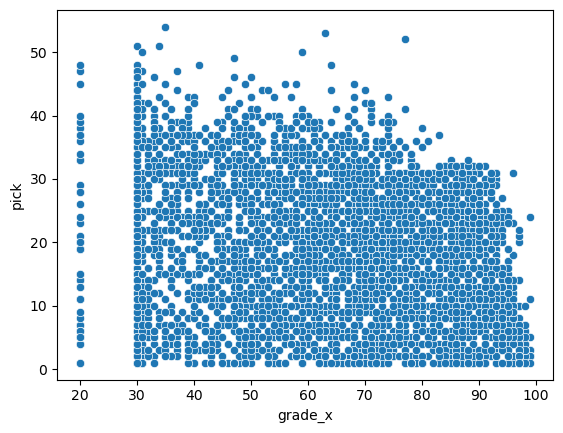

In [32]:

sns.scatterplot(x=df['grade_x'], y=df['pick'])
plt.show()
# why are players with low grades being picked first overall? why does the y axis only go to 40 when the picks
#go well into the hundreds?
# Answer: must factor round into the pick number (this can be found in data set as 'overall')

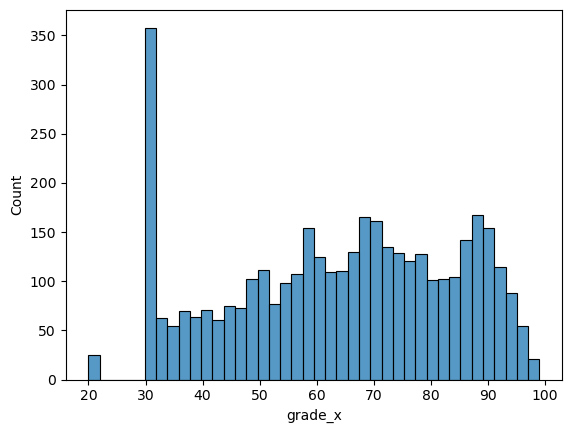

In [11]:
#make a histogram of the explanatory variable
sns.histplot(df['grade_x'], bins=40)
#appears that the lower end has a disproportional occurences, possibly due to lack of coverage/knowledge of these players
#clip lower values of grades column to avoid factoring innacurrate/lazy ratings into the model
df = df[df['grade_x']>50]

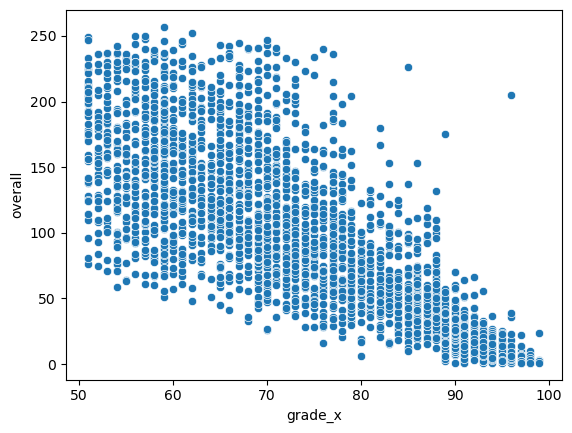

<AxesSubplot:xlabel='grade_x', ylabel='Count'>

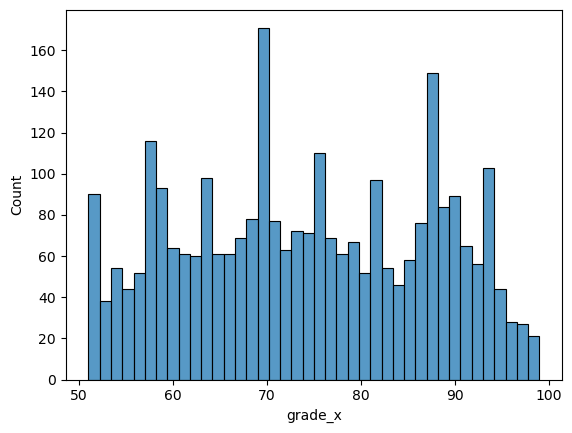

In [14]:
#rerun histogram and scatter plot with the y value as overall
sns.scatterplot(x=df['grade_x'], y=df['overall'])
plt.show()

sns.histplot(df['grade_x'], bins=40)


C:\Users\iejoh\AppData\Local\Temp\ipykernel_21780\1046229921.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<AxesSubplot:>

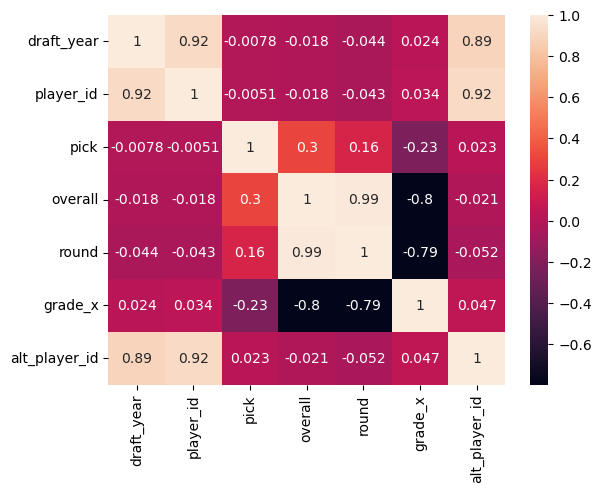

In [14]:
sns.heatmap(df.corr(), annot=True)

#are dependant variable overall has a strong pearson coefficient with the grade_x column which we expected to be true

<AxesSubplot:xlabel='grade_x', ylabel='overall'>

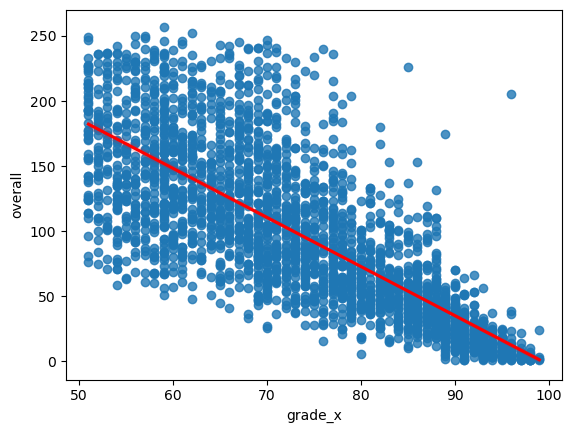

In [16]:
#plot a line of best fit to see where the correlation lies
sns.regplot(x=df['grade_x'], y=df['overall'], line_kws={"color": "red"})

In [11]:
#make training and test data splits using sklearn to visualize how well draft grade_x predicts overall draft pick order.
X = df[["grade_x"]] 
y = df[["overall"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [12]:
rModel = linear_model.LinearRegression(normalize=True)

rModel_results = rModel.fit(X_train, y_train)

C:\Users\iejoh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [13]:
y_pred = rModel.predict(X_test)

0.6276326742678638
root_mean_squared_error :  42.68034120553291


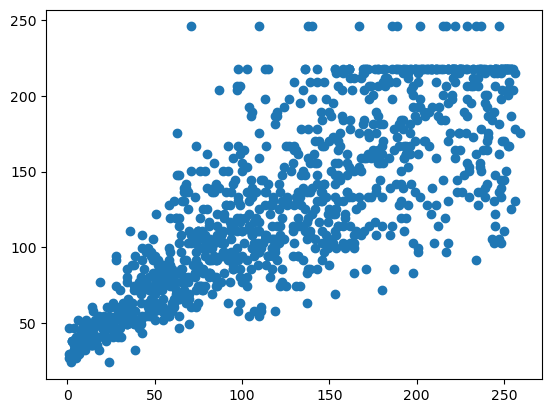

In [14]:

plt.scatter(y_test,y_pred)

print(rModel.score(X_train, y_train))
print('root_mean_squared_error : ', mean_squared_error(y_test, y_pred)**0.5)



# R value of .59 indicates a strong correlation between draft grade and draft grade_x and the overall pick.

The next step would be using nlp to create a metric for sentiment on how the players are talked about and use this in addition to the player grade to run a multiple linear regression model to potentially improve the predictive power of the model. I would train on historical data and use the current year draft as the test data.

In [41]:
df.head()

draft_year     player_name_x pos_abbr_x              school_x  \
7202        2004       Eli Manning         QB              Ole Miss   
7203        2004    Robert Gallery         OT                  Iowa   
7204        2004  Larry Fitzgerald         WR            Pittsburgh   
7205        2004     Philip Rivers         QB  North Carolina State   
7206        2004       Sean Taylor         DB                 Miami   

     school_name_x  pick  overall  round                 team  \
7202        Rebels   1.0      1.0    1.0   San Diego Chargers   
7203      Hawkeyes   2.0      2.0    1.0      Oakland Raiders   
7204      Panthers   3.0      3.0    1.0    Arizona Cardinals   
7205      Wolfpack   4.0      4.0    1.0      New York Giants   
7206    Hurricanes   5.0      5.0    1.0  Washington Redskins   

                                guid_x  grade_x text  
7202  629fd2c16c50e8e3b30799a84fab0d67     98.0       
7203  40a707c142d8bfd1d8595b06639ce4d3     99.0       
7204  ac54c670e31f92e25b9ce4b1d4d00e00     99.0       
7205                               NaN     95.0       
7206  0f6a6624652110a59966cb716e9f1080     99.0

In [15]:
#get rid of non usefull columns
df = df.drop(['player_id', 'alt_player_id', 'guid_x', 'school_name_x'], axis='columns')


In [54]:
df.dtypes

draft_year          int64
player_name_x      object
pos_abbr_x       category
school_x         category
pick              float64
overall           float64
round             float64
team             category
grade_x           float64
text               object
dtype: object

In [16]:
le = LabelEncoder()
df[['pos_num', 'school_num', 'team_num']] = df[['pos_abbr_x', 'school_x', 'team']].apply(le.fit_transform)  # select object type columns that will be used in the model and make numeric


In [60]:
""""
#turn df bool into numeric values for analysis
dfnumeric = df.select_dtypes(include=['bool'])
df = pd.concat([df.drop(dfnumeric, axis=1), dfnumeric.astype(int)], axis=1 )


In [61]:
df.head()

draft_year     player_name_x pos_abbr_x              school_x  pick  \
7202        2004       Eli Manning         QB              Ole Miss   1.0   
7203        2004    Robert Gallery         OT                  Iowa   2.0   
7204        2004  Larry Fitzgerald         WR            Pittsburgh   3.0   
7205        2004     Philip Rivers         QB  North Carolina State   4.0   
7206        2004       Sean Taylor         DB                 Miami   5.0   

      overall  round                 team  grade_x text  pos_num  school_num  \
7202      1.0    1.0   San Diego Chargers     98.0            15         181   
7203      2.0    1.0      Oakland Raiders     99.0            12          98   
7204      3.0    1.0    Arizona Cardinals     99.0            19         188   
7205      4.0    1.0      New York Giants     95.0            15         162   
7206      5.0    1.0  Washington Redskins     99.0             2         127   

      team_num  
7202        28  
7203        25  
7204         0  
7205        23  
7206        35

In [63]:
df['pos_abbr_x'].unique()

array(['QB', 'OT', 'WR', 'DB', 'TE', 'LB', 'DT', 'DE', 'RB', 'OG', nan,
       'PK', 'P', 'OLB', 'CB', 'S', 'ILB', 'FB', 'LS', 'KR', 'C'],
      dtype=object)

In [65]:
####### SCALING BEFORE SPLIT CAUSES DATA LEAKAGE but still the same metric results?
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler
MM_scaler = MinMaxScaler()

# Fit MM_scaler to the data
MM_scaler.fit(df[['overall', 'grade_x', 'pos_num', 'school_num', 'team_num']])

# Transform the data using the fitted scaler
df[['MM_overall', 'MM_grade_x', 'MM_pos_num', 'MM_school_num', 'MM_team_num']] = MM_scaler.transform(df[['overall', 'grade_x', 'pos_num', 'school_num', 'team_num']])

# Compare the origional and transformed column
print(df['MM_overall'].head(-5))

7202     0.000000
7203     0.003876
7204     0.007752
7205     0.011628
7206     0.015504
           ...   
13235    0.957364
13236    0.961240
13237    0.965116
13238    0.968992
13240    0.976744
Name: MM_overall, Length: 4424, dtype: float64


In [128]:
df.head()


draft_year     player_name_x pos_abbr_x              school_x  pick  \
7202        2004       Eli Manning         QB              Ole Miss   1.0   
7203        2004    Robert Gallery         OT                  Iowa   2.0   
7204        2004  Larry Fitzgerald         WR            Pittsburgh   3.0   
7205        2004     Philip Rivers         QB  North Carolina State   4.0   
7206        2004       Sean Taylor         DB                 Miami   5.0   

      overall  round                 team  grade_x text  pos_num  school_num  \
7202      1.0    1.0   San Diego Chargers     98.0            15         181   
7203      2.0    1.0      Oakland Raiders     99.0            12          98   
7204      3.0    1.0    Arizona Cardinals     99.0            19         188   
7205      4.0    1.0      New York Giants     95.0            15         162   
7206      5.0    1.0  Washington Redskins     99.0             2         127   

      team_num  MM_overall  MM_grade_x  MM_pos_num  MM_school_num  MM_team_num  
7202        28    0.000000    0.987342        0.75       0.624138     0.800000  
7203        25    0.003876    1.000000        0.60       0.337931     0.714286  
7204         0    0.007752    1.000000        0.95       0.648276     0.000000  
7205        23    0.011628    0.949367        0.75       0.558621     0.657143  
7206        35    0.015504    1.000000        0.10       0.437931     1.000000

In [17]:
#assign input columns to X and predicted y columns to y
X = df[['grade_x', 'pos_num', 'school_num', 'team_num']]
y = df[['overall']]
 

In [18]:
#create a train test split with clean wide data 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

# Multiple Linear Regression Model

In [131]:
lrm = linear_model.LinearRegression()
lrm_fit = lrm.fit(X_train, y_train)
print(lrm_fit.score(X_train, y_train))

0.6286000629764585


In [132]:
#get the RMSE (same units as target variable)
y_pred = lrm_fit.predict(X_test)
print('root_mean_squared_error : ', mean_squared_error(y_test, y_pred)**0.5)

#results or RMSE show that this model does not benifit from any of the additional ordinal information 
#when training the model

root_mean_squared_error :  42.654882048590274


Text(0, 0.5, 'Predicted')

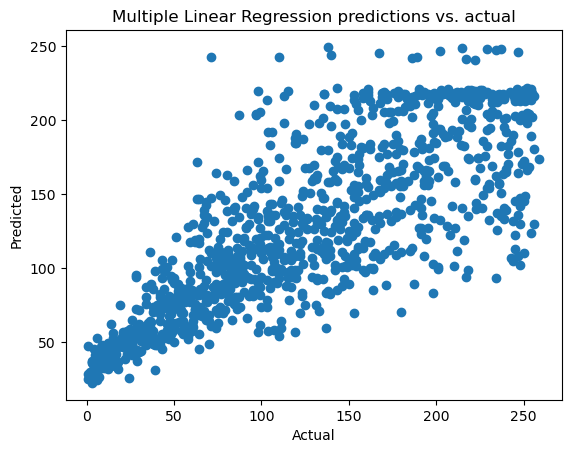

In [99]:
# Plot the predictions
# Build a scatterplot
plt.scatter(y_test, y_pred)

# Label graph
plt.title("Multiple Linear Regression predictions vs. actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Random Forest Regressor Model

In [161]:
#instantiate a random forest regressor model with params and fit it
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 7, random_state = 18).fit(X_train, y_train.values.ravel())

In [162]:
#predict values with model
rf_y_pred = rf.predict(X_test)

In [163]:
print('root_mean_squared_error : ', mean_squared_error(y_test, rf_y_pred)**0.5)

root_mean_squared_error :  41.49042890201791


In [167]:
print(rf.feature_importances_, X.columns)

[0.93268501 0.01734669 0.03027428 0.01969403] Index(['grade_x', 'pos_num', 'school_num', 'team_num'], dtype='object')


# SVR Model

In [20]:
#train and test a linear svr model
svr = SVR(kernel='linear')
svr_fitted = svr.fit(X_train, y_train.values.ravel())
svr_y_pred = svr.predict(X_test)
print('root_mean_squared_error : ', mean_squared_error(y_test, svr_y_pred)**0.5)


root_mean_squared_error :  43.22278269444763


In [23]:
#train and test a rbf svr model
svr = SVR(kernel='rbf')
svr_fitted = svr.fit(X_train, y_train.values.ravel())
svr_y_pred = svr.predict(X_test)
print('root_mean_squared_error : ', mean_squared_error(y_test, svr_y_pred)**0.5)

root_mean_squared_error :  48.167747620972065


In [ ]:
'''''
The model with the least amount of error on the test date is the random forest model. The data set is small
and training time is a non issue 
'''''
